### Testing Neural Network based Anomaly Detection on actual data

#### This code reads PerfSONAR measured packet loss rates between a specified endpoint and all other endpoints in a selected time range. It tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [13]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

from time import time

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

#### parameters to set

In [14]:
n_series = 20 # not use all the series for the tutorial

start_date = '2017-05-13 00:00:00'
end_date = '2017-05-20 23:59:59'

# tuning parameters
ref = 24
sub = 1
chance = ref/(sub+ref)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = ref * Hour()
sub = sub * Hour()


sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"

dS='pic'
destSiteOWDServer = "193.109.172.188"

chance: 0.96 	cut: 0.962


## get data from ES

In [15]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.*"

start = pd.Timestamp(start_date)
end   = pd.Timestamp(end_date)

my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': start.strftime('%Y%m%dT%H%M00Z'), 'lt': end.strftime('%Y%m%dT%H%M00Z')}}},
                    {'term': {'src': srcSiteOWDServer}},
                    {'term': {'_type': 'packet_loss_rate'}}
                    ]
               }
        }
}


scroll = scan(client=es, index=indices, query=my_query)

### scan the data

In [16]:
count = 0
allData={} # will be like this: {'dest_host':[[timestamp],[value]], ...} 
for res in scroll:
#     if count<2: print(res) 
    if not count%100000: print(count)
    if count>1000000: break
    dst = res['_source']['dest'] # old data - dest, new data - dest_host
    if dst not in allData: allData[dst]=[[],[]]
    allData[dst][0].append(res['_source']['timestamp'] )
    allData[dst][1].append(res['_source']['packet_loss'])
    
    count=count+1

dfs=[]
for dest,data in allData.items():
    ts=pd.to_datetime(data[0],unit='ms')
    df=pd.DataFrame({dest:data[1]}, index=ts )
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda t: t.replace(second=0))
    df = df[~df.index.duplicated(keep='last')]
    dfs.append(df)
    #print(df.head(2))

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [17]:
full_df = pd.concat(dfs, axis=1)

In [19]:
print(full_df.shape)
full_df.head()
#print(full_df.columns )

(11519, 73)


,131.169.98.30,150.244.246.85,134.158.20.192,134.75.125.241,193.144.80.12,158.195.14.26,193.48.83.165,134.158.103.10,146.83.90.7,81.180.86.64,...,193.140.98.8,169.228.130.40,194.190.165.192,192.108.47.12,212.193.96.29,147.231.25.192,194.80.35.169,194.36.11.38,148.187.64.25,159.93.229.151
2017-05-13 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:01:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.001667,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:02:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.001667,0.0,0.0,0.0,0.0,NaN,0.0
2017-05-13 00:03:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001667,0.000000,0.0,...,0.0,0.0,0.0,0.001667,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-13 00:04:00,0.0,0.0,0.001667,0.0,0.0,0.0,0.0,0.000000,0.018333,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


#### plot timeseries

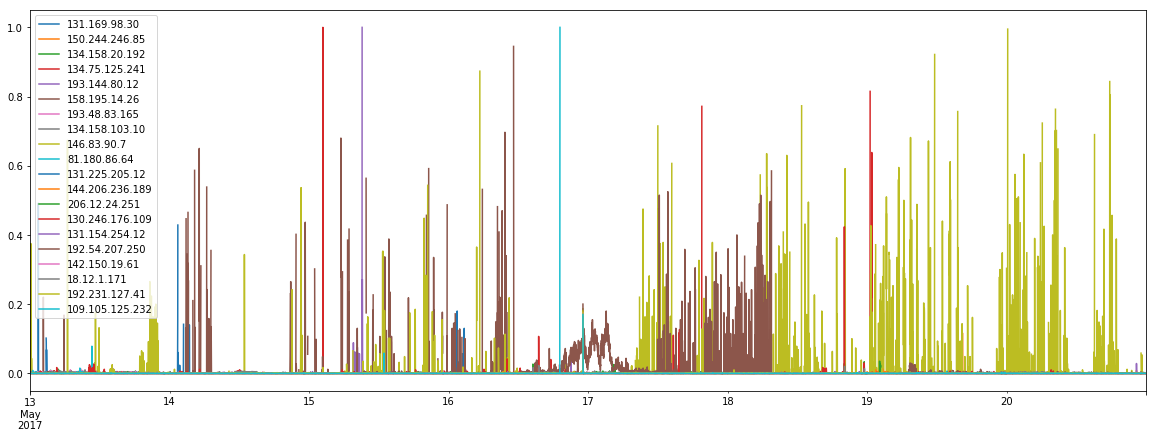

In [20]:
full_df.iloc[:,0:n_series].plot(figsize=(20,7))

### create Network Model

In [21]:
class ANN(object):
    def __init__(self, n_series):
        self.n_series = n_series
        self.df = None
        self.auc_df = None
        
        self.nn = Sequential()
        self.nn.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=n_series, activation='relu'))
#       self.nn.add(Dropout(0.5))
        self.nn.add(Dense(units=1, activation='sigmoid'))
#       self.nn.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#       self.nn.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        self.nn.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#       self.nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        self.nn.summary()
    
    def set_data(self, df, auc_df):
        self.df = df
        self.auc_df = auc_df
    
    def plot_hist(self, hist):
        es=len(hist.history['loss'])
        x = np.linspace(0,es-1,es)
        plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
        plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
        plt.legend()
        plt.show()
    
    def check_for_anomaly(self,ref, sub, count):
    
        y_ref = pd.Series([0] * ref.shape[0])
        X_ref = ref
    
        y_sub = pd.Series([1] * sub.shape[0])
        X_sub = sub
        
        # separate Reference and Subject into Train and Test
        X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
        X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
        # combine training ref and sub samples
        X_train = pd.concat([X_ref_train, X_sub_train])
        y_train = pd.concat([y_ref_train, y_sub_train])

        # combine testing ref and sub samples
        X_test = pd.concat([X_ref_test, X_sub_test])
        y_test = pd.concat([y_ref_test, y_sub_test])
    
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
    
        X_train_s, y_train_s = shuffle(X_train, y_train)
    
        hist = self.nn.fit(X_train_s.values, y_train_s.values, epochs=100, verbose=0, shuffle=True, batch_size=10)
        loss_and_metrics = self.nn.evaluate(X_test.values, y_test.values)#, batch_size=256)
        #print(loss_and_metrics)
    
        if loss_and_metrics[1] > cut or not count%5: 
            self.plot_hist(hist)
        
        return scaled_accuracy(loss_and_metrics[1], ref.shape[0], sub.shape[0])
    
    
    def loop_over_intervals(self):
        lstart = self.df.index.min()
        lend = self.df.index.max()

        #round start 
        lstart.seconds=0
        lstart.minutes=0

        # loop over them
        ti = lstart + ref + sub
        count = 0
        while ti < lend + 1 * Minute():
            print(count)
            startt = time()
            ref_start = ti-ref-sub
            ref_end = ti-sub
            ref_df = self.df[(self.df.index >= ref_start) & (self.df.index < ref_end)]
            sub_df = self.df[(self.df.index >= ref_end) & (self.df.index < ti)]
            score = self.check_for_anomaly(ref_df, sub_df, count)
            self.auc_df.loc[(self.auc_df.index >= ref_end) & (self.auc_df.index < ti), ['score']]  = score
            print('\n',ti,"\trefes:" , ref_df.shape, "\tsubjects:", sub_df.shape, '\tacc:', score)
            ti = ti + sub
            print("took:", time()-startt)
            count = count + 1
            #if count>2: break    
    
    
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#   model.add(Dropout(0.5))
    model.add(Dense(units=n_series, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    
#   model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#   model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#   model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
    
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [22]:
def scaled_accuracy(accuracy, ref_samples, sub_samples):
    chance = float(ref_samples)/(ref_samples+sub_samples)
    rescale = 1/(1 - chance)
    return (accuracy-chance)*rescale


### fix NANs

In [23]:
# full_df.interpolate(method='nearest', axis=0, inplace=True)
full_df.fillna(0, inplace=True)

### select part of the data

In [24]:
df = full_df.iloc[:,0:n_series]
auc_df = pd.DataFrame(np.nan, index=df.index, columns=['score'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________
0
 32/450 [=>............................] - ETA: 0s

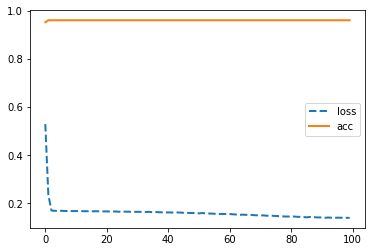


 2017-05-14 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.032667636871338
1
 32/450 [=>............................] - ETA: 0s
 2017-05-14 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.272700786590576
2
 32/450 [=>............................] - ETA: 0s

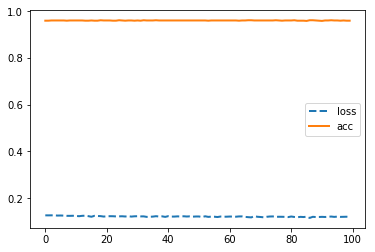


 2017-05-14 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0555555555556
took: 30.66571593284607
3
 32/450 [=>............................] - ETA: 0s
 2017-05-14 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.858262062072754
4
 32/450 [=>............................] - ETA: 0s
 2017-05-14 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.452377557754517
5
 32/450 [=>............................] - ETA: 0s

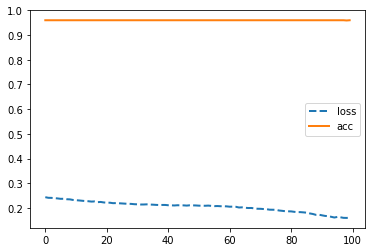


 2017-05-14 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.58342480659485
6
 32/450 [=>............................] - ETA: 0s
 2017-05-14 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.865617513656616
7
 32/450 [=>............................] - ETA: 0s
 2017-05-14 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.63571286201477
8
 32/450 [=>............................] - ETA: 0s
 2017-05-14 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.588606357574463
9
 32/450 [=>............................] - ETA: 0s
 2017-05-14 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.39937424659729
10
 32/450 [=>............................] - ETA: 0s

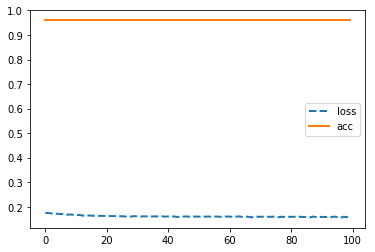


 2017-05-14 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.984727382659912
11
 32/450 [=>............................] - ETA: 0s

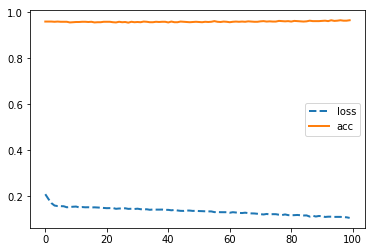


 2017-05-14 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.222222222222
took: 29.279242038726807
12
 32/450 [=>............................] - ETA: 0s

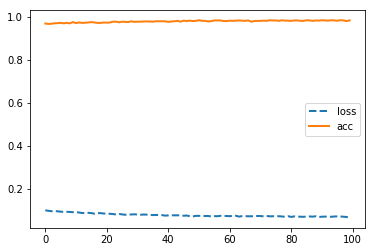


 2017-05-14 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.111111111111
took: 28.840492010116577
13
 32/450 [=>............................] - ETA: 0s
 2017-05-14 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.166666666667
took: 29.14905095100403
14
 32/450 [=>............................] - ETA: 0s
 2017-05-14 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.397934436798096
15
 32/450 [=>............................] - ETA: 0s

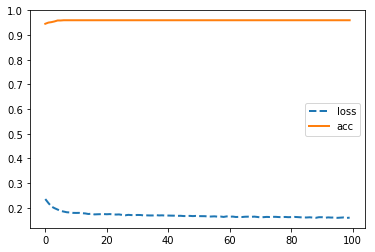


 2017-05-14 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.128420114517212
16
 32/450 [=>............................] - ETA: 0s
 2017-05-14 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.02935218811035
17
 32/450 [=>............................] - ETA: 0s
 2017-05-14 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.261893033981323
18
 32/450 [=>............................] - ETA: 0s
 2017-05-14 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.09100365638733
19
 32/450 [=>............................] - ETA: 0s
 2017-05-14 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.03441596031189
20
 32/450 [=>............................] - ETA: 0s

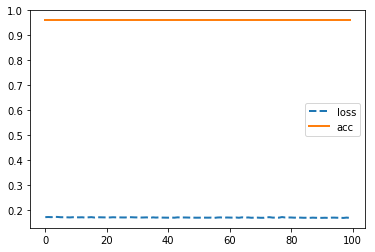


 2017-05-14 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.626199960708618
21
 32/450 [=>............................] - ETA: 0s
 2017-05-14 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.13145422935486
22
 32/450 [=>............................] - ETA: 0s
 2017-05-14 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.722058057785034
23
 32/450 [=>............................] - ETA: 0s
 2017-05-15 00:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.451396942138672
24
 32/450 [=>............................] - ETA: 0s
 2017-05-15 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.565937995910645
25
 32/450 [=>............................] - ETA: 0s

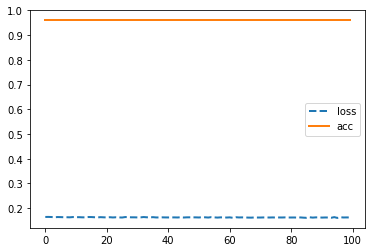


 2017-05-15 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.95697784423828
26
 32/450 [=>............................] - ETA: 0s
 2017-05-15 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.693732261657715
27
 32/450 [=>............................] - ETA: 0s
 2017-05-15 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.831716775894165
28
 32/450 [=>............................] - ETA: 0s
 2017-05-15 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.68874478340149
29
 32/450 [=>............................] - ETA: 0s
 2017-05-15 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.042630672454834
30
 32/450 [=>............................] - ETA: 0s

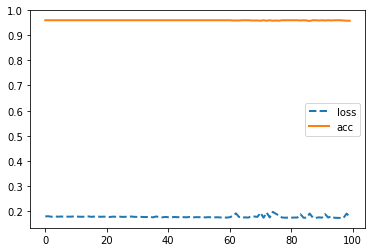


 2017-05-15 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.94657325744629
31
 32/450 [=>............................] - ETA: 0s
 2017-05-15 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.765363931655884
32
 32/450 [=>............................] - ETA: 0s
 2017-05-15 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 28.510982751846313
33
 32/450 [=>............................] - ETA: 0s
 2017-05-15 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.05291748046875
34
 32/450 [=>............................] - ETA: 0s
 2017-05-15 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 29.60537552833557
35
 32/450 [=>............................] - ETA: 0s

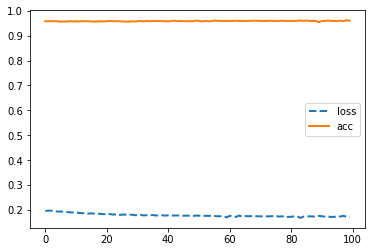


 2017-05-15 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.166666666667
took: 28.994053602218628
36
 32/450 [=>............................] - ETA: 0s
 2017-05-15 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 28.63163471221924
37
 32/450 [=>............................] - ETA: 0s
 2017-05-15 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.880685091018677
38
 32/450 [=>............................] - ETA: 0s
 2017-05-15 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.593514442443848
39
 32/450 [=>............................] - ETA: 0s
 2017-05-15 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.017394065856934
40
 32/450 [=>............................] - ETA: 0s

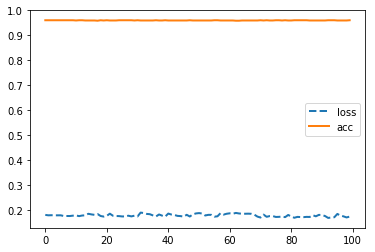


 2017-05-15 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 32.61002540588379
41
 32/450 [=>............................] - ETA: 0s
 2017-05-15 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.861740589141846
42
 32/450 [=>............................] - ETA: 0s
 2017-05-15 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 28.587986946105957
43
 32/450 [=>............................] - ETA: 0s
 2017-05-15 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.774360179901123
44
 32/450 [=>............................] - ETA: 0s
 2017-05-15 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.868725299835205
45
 32/450 [=>............................] - ETA: 0s

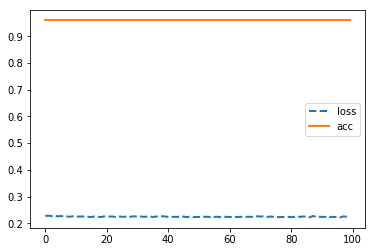


 2017-05-15 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.762102365493774
46
 32/450 [=>............................] - ETA: 0s
 2017-05-15 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.34579610824585
47
 32/450 [=>............................] - ETA: 0s
 2017-05-16 00:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.362731456756592
48
 32/450 [=>............................] - ETA: 0s
 2017-05-16 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: -0.0555555555556
took: 28.401568174362183
49
 32/450 [=>............................] - ETA: 0s
 2017-05-16 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.079963207244873
50
 32/450 [=>............................] - ETA: 0s

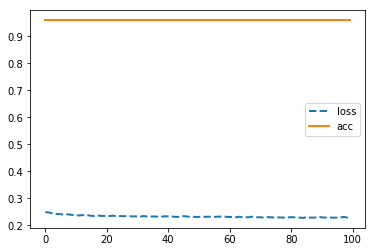


 2017-05-16 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.887015104293823
51
 32/450 [=>............................] - ETA: 0s

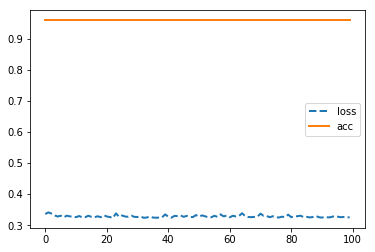


 2017-05-16 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.03672480583191
56
 32/450 [=>............................] - ETA: 0s
 2017-05-16 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.10622262954712
57
 32/450 [=>............................] - ETA: 0s
 2017-05-16 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.06072235107422
58
 32/450 [=>............................] - ETA: 0s
 2017-05-16 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.966493368148804
59
 32/450 [=>............................] - ETA: 0s
 2017-05-16 12:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.35821294784546
60
 32/450 [=>............................] - ETA: 0s

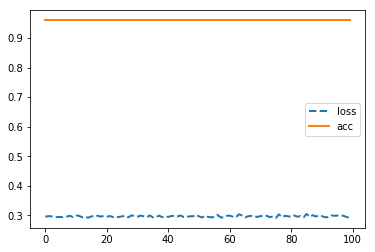


 2017-05-16 13:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.67658257484436
61
 32/450 [=>............................] - ETA: 0s
 2017-05-16 14:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.851189613342285
62
 32/450 [=>............................] - ETA: 0s
 2017-05-16 15:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.690268993377686
63
 32/450 [=>............................] - ETA: 0s
 2017-05-16 16:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.24555802345276
64
 32/450 [=>............................] - ETA: 0s
 2017-05-16 17:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.786036729812622
65
 32/450 [=>............................] - ETA: 0s

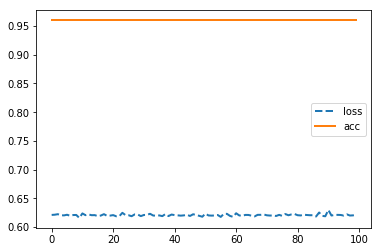


 2017-05-16 18:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.358455896377563
66
 32/450 [=>............................] - ETA: 0s
 2017-05-16 19:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.240488290786743
67
 32/450 [=>............................] - ETA: 0s
 2017-05-16 20:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.05064845085144
68
 32/450 [=>............................] - ETA: 0s
 2017-05-16 21:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 31.185080528259277
69
 32/450 [=>............................] - ETA: 0s
 2017-05-16 22:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 27.936073064804077
70
 32/450 [=>............................] - ETA: 0s

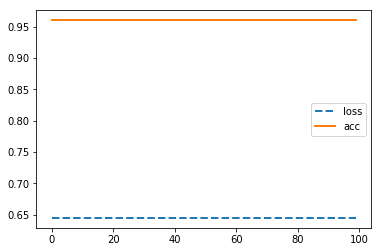


 2017-05-16 23:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.144774436950684
71
 32/450 [=>............................] - ETA: 0s
 2017-05-17 00:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.425269842147827
72
 32/450 [=>............................] - ETA: 0s
 2017-05-17 01:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.282392740249634
73
 32/450 [=>............................] - ETA: 0s
 2017-05-17 02:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.41483783721924
74
 32/450 [=>............................] - ETA: 0s
 2017-05-17 03:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.32894468307495
75
 32/450 [=>............................] - ETA: 0s

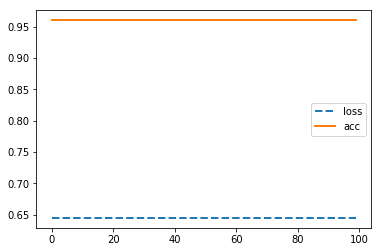


 2017-05-17 04:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.374945163726807
76
 32/450 [=>............................] - ETA: 0s
 2017-05-17 05:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.25355625152588
77
 32/450 [=>............................] - ETA: 0s
 2017-05-17 06:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.88942837715149
78
 32/450 [=>............................] - ETA: 0s
 2017-05-17 07:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.663640022277832
79
 32/450 [=>............................] - ETA: 0s
 2017-05-17 08:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 30.882304191589355
80
 32/450 [=>............................] - ETA: 0s

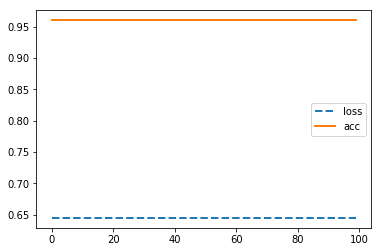


 2017-05-17 09:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.616061210632324
81
 32/450 [=>............................] - ETA: 0s
 2017-05-17 10:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 28.78215265274048
82
 32/450 [=>............................] - ETA: 0s
 2017-05-17 11:00:00 	refes: (1440, 20) 	subjects: (60, 20) 	acc: 0.0
took: 29.372684955596924
83


In [ ]:
ann = ANN(n_series)
ann.set_data(df, auc_df)
ann.loop_over_intervals()

In [ ]:
df.plot(figsize=(20,7))


In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
auc_df['Detected'] = 0
auc_df.loc[auc_df.score>0.05, ['Detected']]=1
ax.plot( auc_df.score,'g')
ax.fill( auc_df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()